# Calibration Procedure

### Input parameters

In [98]:
scan_file = '/homelocal/rhoms/develop/tmp/clear_data/20190404.dat'
scan_id = 318093
auto_roi = True
user_roi = (0, BAD_PIXEL)
threshold = 0.7
noise_percent = 10
energy_resolution = 0.03
show_plot = False
i0_name='n_i0_1'

#### Import libraries

In [99]:
import sys
import numpy as np
from scipy.optimize import fmin, curve_fit
from scipy.interpolate import interp1d
sys.path.append('/homelocal/rhoms/develop/pycharm/BL22ClearData/bl22cleardata')
sys.path.append('/homelocal/rhoms/develop/pycharm/Crystal/')
from bl22cleardata.specreader import read_scan



#### Preare matplotlib to plot inline

In [100]:
%matplotlib inline
from matplotlib import pyplot as plt
def plot(data):
    if len(data.shape) == 1:
        plt.plot(data)
    else:
        for i in data:
            plt.plot(i)


### Method to normalize Mythen data

In [101]:
M_RAW = 'm_raw'
BAD_PIXEL = 1140

def get_mythen_data(data, i0_name):
    """
    Method to extract the Mythen data from the raw data. It normalizes the
    Mythen data by the I0 and remove the bad channels.
    :param data: Dictionary with the raw data
    :type: dict
    :return: Mythen date pre-prosed
    :type: numpy.array
    """

    m_raw = np.array(data[M_RAW])
    i0 = np.array(data[i0_name])

    # Remove bad pixels
    m_raw = m_raw[:, range(BAD_PIXEL)]

    # Normalize the mythen data
    m_norm = (m_raw / i0[:, np.newaxis]) * i0.mean()
    return m_norm


### Read data

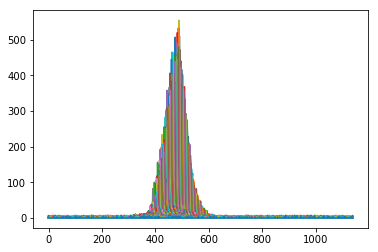

In [102]:
data, snapshots = read_scan(scan_file, scan_id)
energies = np.array(data[ENERGY])
m_data = get_mythen_data(data, i0_name)
plot(m_data)       
    

### Calculate a and b for energy scale, Lineal regression

In [103]:
def normalize(x, scale_min=0., scale_max=1.):
    """
    Normalize the signal by the MaxMin Scaler method
    Xmin = min(X)
    Xmax = max(X)
             X - Xmin
    Xnorm = -------------
             Xmax - Xmin

    Additional it is possible to change the scale
    Xnorm_scaled = (scale_max - scale_min) * Xnorm + scale_min

    :param x: Data vector
    :type: numpy.array
    :param scale_min: Minimum value of the new scale
    :type: float
    :param scale_max: Maximum value of the new scale
    :type: float

    :return: Normalized and rescaled data vector
    :type: numpy.array
    """
    x_min = float(x.min())
    x_max = float(x.max())
    if x_max == x_min:
        return x
    x_norm = (x - x_min) / (x_max - x_min)

    x_rescaled = (scale_max - scale_min) * x_norm + scale_min

    return x_rescaled


def probability_distribution(x, order=2):
    """
    Calculate the probability distribution
    :param x: Data vector
    :type: numpy.array
    :param order:
    :type: int
    :return:
    """
    x = normalize(x, 0., 1.)
    x = x ** order
    x = x / x.sum()
    return x


def linear_regression(img, threshold=0.7, order=2):
    """
    Calculate the linear regression
    :param img: Image
    :type: numpy.array
    :param threshold: Min value threshold [0,1]
    :type: float
    :param order: Probability distribution order
    :return:
    """
    img_norm = normalize(img)
    img_clipped = img_norm.clip(min=threshold, max=1)
    pd_xy = probability_distribution(img_clipped, order=order)
    x_idx = np.arange(img.shape[1])
    y_idx = np.arange(img.shape[0])
    XY = y_idx.reshape((y_idx.size, 1)) * x_idx
    Px = pd_xy.sum(axis=0)  # marginal distribution of probability
    Py = pd_xy.sum(axis=1)  # marginal distribution of probability
    Xmean = (Px*x_idx).sum()  # calculation of <X>
    Ymean = (Py*y_idx).sum()  # calculation of <Y>
    X2mean = (Px*x_idx**2).sum()  # calculation of <X^2>
    Y2mean = (Py*y_idx**2).sum()  # calculation of <Y^2>
    XYmean = (pd_xy * XY).sum()  # calculation of <XY>
    a = (XYmean - Xmean*Ymean) / (X2mean - Xmean**2)
    b = Ymean - a*Xmean
    Xstd = np.sqrt(X2mean - Xmean**2)
    Ystd = np.sqrt(Y2mean - Ymean**2)
    return a, b, Xmean, Ymean, Xstd, Ystd



In [104]:
a, b, x_mean, y_mean, x_std, y_std = linear_regression(m_data,
                                                       threshold)

### Calculate autoROIs

In [105]:
def calc_autoroi(m_data, noise_percent=2.5):
    m_norm = normalize(m_data)
    m_roi_x = m_norm.sum(axis=0)

    # Reduce noise
    noise_level = m_roi_x.max() * (noise_percent / 100)
    m_roi_x_clipped = m_roi_x.clip(min=noise_level)
    diff_m_roi = np.diff(np.diff(m_roi_x_clipped))
    plot(m_roi_x_clipped)
    diff_norm = normalize(diff_m_roi)
    plot(diff_m_roi)
    r = np.where(diff_norm > diff_norm.mean()+1e-4)[0]
    auto_roi_low = int(r[0])
    auto_roi_high = int(r[-1])
    print('AutoROIs low:{0} high:{1}'.format(auto_roi_low, auto_roi_high))
    return auto_roi_low, auto_roi_high

AutoROIs low:372 high:586


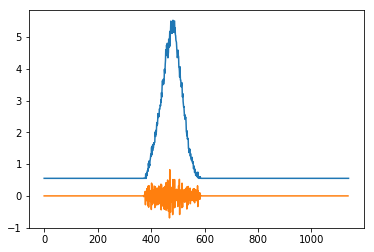

In [106]:
# Calculate autoROIs
if auto_roi:
    roi_low, roi_high = calc_autoroi(m_data, noise_percent)
else:
    roi_low, roi_high = user_roi
# The original code use only the noise form 0 to a pixel_limit_
# noise 600. Refactor to use the data out of the roi
if roi_low == 0:
    low_noise = 0
else:
    low_noise = m_data[:, 0:roi_low].mean()
if roi_high == BAD_PIXEL:
    high_noise = 0
else:
    high_noise = m_data[:, roi_high:BAD_PIXEL].mean()
noise = (low_noise + high_noise) / 2

## Calculate the 2D dispersion


In [107]:
def dispersion_2d(a, x0, y0, alpha, beta, X, Y):
    XX = X - x0
    YY = Y - y0
    arg = 0.5 * (((XX - YY / a) / alpha) ** 2) + 0.5 * ((YY / beta) ** 2)
    z = 1 / (2 * np.pi * alpha * beta) * np.exp(-arg)
    if z.sum() == 0:
        return 0
    return z / z.sum()


In [108]:
# Calculate 2D dispersion
m_wn = m_data - noise
m_wroi = m_wn[:, roi_low:roi_high]
d = m_wroi / m_wroi.sum()

x, y = np.meshgrid(np.arange(m_wroi.shape[1]),
                   np.arange(m_wroi.shape[0]))
cost = lambda v: ((dispersion_2d(a, x_mean, y_mean,
                                 x_std, y_std, x, y) - d) ** 2).sum()
new_a, new_x_mean, new_y_mean, new_x_std, new_y_std = \
    fmin(cost, [a, x_mean, y_mean, x_std, y_std])

new_b = y_mean - new_a * new_x_mean

if np.abs((new_a - a) / a) < 0.1:
    # Use 2D dispersion fitting
    a = new_a
    b = new_b
    x_mean = new_x_mean
    y_mean = new_y_mean

Optimization terminated successfully.
         Current function value: 0.056758
         Iterations: 19
         Function evaluations: 132


### Calculate k factor

In [109]:
# Calculate the scale factor index vs energy_mono:
# energy = k*i + energy[0]
k = (energies[-1] - energies[0]) / float(len(energies) - 1)
energy_a = k * a
energy_b = k * b + energies[0]


In [110]:
def pixel2energy(pixels):
    return energy_a * pixels + energy_b


### Calculate p0 and e0

In [111]:
# Calculate p0 and e0
x = np.arange(m_wroi.shape[1])
disp_exp = m_wroi.max(axis=0)
x_max, x_mean, x_std = get_best_fit(x, disp_exp, gauss_function)
p0 = int(x_mean + roi_low)
e0 = pixel2energy(p0)
print('p0={} e0={}'.format(p0, e0))

# Calculate energy scale vector
m_calib = m_wn.sum(axis=0)

p0=476 e0=7058.709499809023


### Calculate calibration and resolution

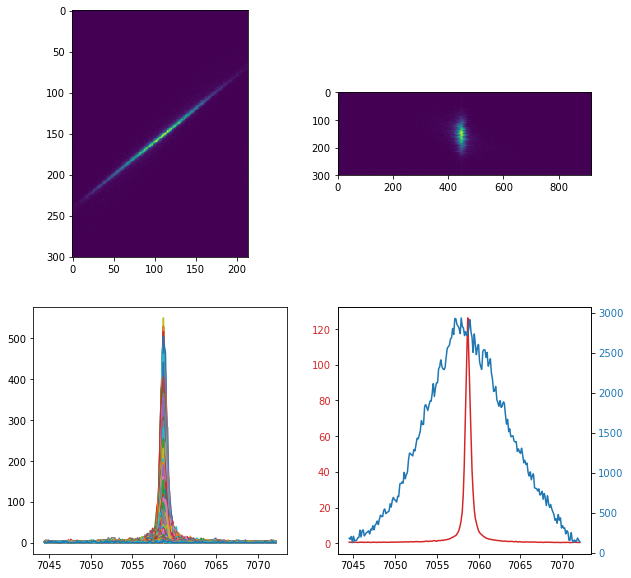

In [112]:
min_scale = pixel2energy(roi_low)
max_scale = pixel2energy(roi_high)

discrete_energy_scale = pixel2energy(range(0, BAD_PIXEL))
energy_step = int(abs((max_scale - min_scale)/energy_resolution))
continue_energy_scale = np.linspace(min_scale, max_scale, energy_step)
nr_points = m_data.shape[0]
resolution_matrix = np.zeros([nr_points, energy_step])
f = interp1d(discrete_energy_scale, m_wn.sum(axis=0),
             bounds_error=False, fill_value=0)
m_calib = f(continue_energy_scale)
for idx, i in enumerate(m_data):
    e0_delta = pixel2energy(m_data[idx].argmax()) - e0
    f = interp1d(discrete_energy_scale - e0_delta, i,
                 bounds_error=False, fill_value=0)
    resolution_matrix[idx] = f(continue_energy_scale)
m_resolution = resolution_matrix.sum(axis=0) / nr_points
m_energy_scale = continue_energy_scale
m_data = m_data

# TODO: Evaluate if to use thread to not block
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].imshow(m_wn[:, roi_low:roi_high])
axs[0, 1].imshow(resolution_matrix)
for i in resolution_matrix:
    axs[1, 0].plot(m_energy_scale, i)
color = 'tab:red'
axs1 = axs[1, 1]
axs1.tick_params(axis='y', labelcolor=color)
axs1.plot(m_energy_scale, m_resolution,
          color=color)

color = 'tab:blue'
axs2 = axs[1, 1].twinx()
axs2.tick_params(axis='y', labelcolor=color)
axs2.plot(m_energy_scale, m_calib, color=color)
plt.show()



### Apply smoothing to the calibration vector

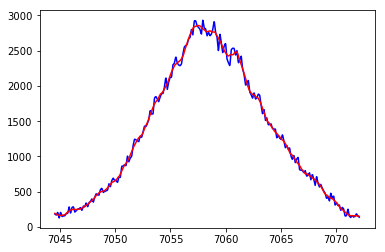

In [135]:
from scipy.signal import savgol_filter
window = 51
order = 3
new_m_calib = savgol_filter(m_calib, window, order)
plt.plot(m_energy_scale, m_calib, '-b',m_energy_scale, new_m_calib, '-r')
